# **Phase 1 - Milestone 2**

**Ediashta Revindra Amirussalam**

FTDS - RMT - 020

## Objective

Galaxy Solusindo adalah sebuah perusahaan yang bergerak pada bidang elektronik khususnya distributor laptop secara nasional, galaxy solusindo ingin menerapkan sebuah sistem pre=order dimana pelanggan dapat melakukan request pemesanan laptop dengan memberikan spesifikasi yang diinginkan, dan akan menampilkan perkiraan harga laptop tersebut.

Oleh karena itu akan dibua sebuah pemodelan yang dapat melakukan yang dapat melakukan regression terhadap harga laptop sesuai dengan spesifikasinya, pada pemodelan ini akan menggunakan 4 model regresi yaitu:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor
- XGBoost Regressor

Dari ke-empat pemodelan tersebut akan diambil model terbaik dengan menggunakan metric Mean Absolute Error dan Root-Mean Squared Error untuk menentukan performa model terhadap data prediksi. setelah ditentukan model terbaik akan dilakukan hyperparameter tuning menggunakan gridsearch untuk memaksimalkan performa model tersebut

Dataset yang digunakan adalah dataset [laptop price dataset - kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset)

## 00 - Import Libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from category_encoders.count import CountEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle, json

In [85]:
pd.reset_option("all")

## 01 - Data Loading

In [86]:
#load data
data  = pd.read_csv('./laptops.csv')

In [87]:
#check head
data.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [88]:
data_copy = data.copy()

## 02 - EDA

In [89]:
#check data basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


Terdapat 11 kolom dan 2160 baris data pada dataset ini, dan terdapat tipe data int, float dan object. pada dataset ini juga terdapat beberapa null values yang akan kita lakukan handling pada feature engineering

In [90]:
#check data basic statistics
data.describe()

,RAM,Storage,Screen,Final Price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


Harga tertinggi pada dataset ini adalah $7150 dan harga terendah adalah $201

<Axes: xlabel='count', ylabel='Brand'>

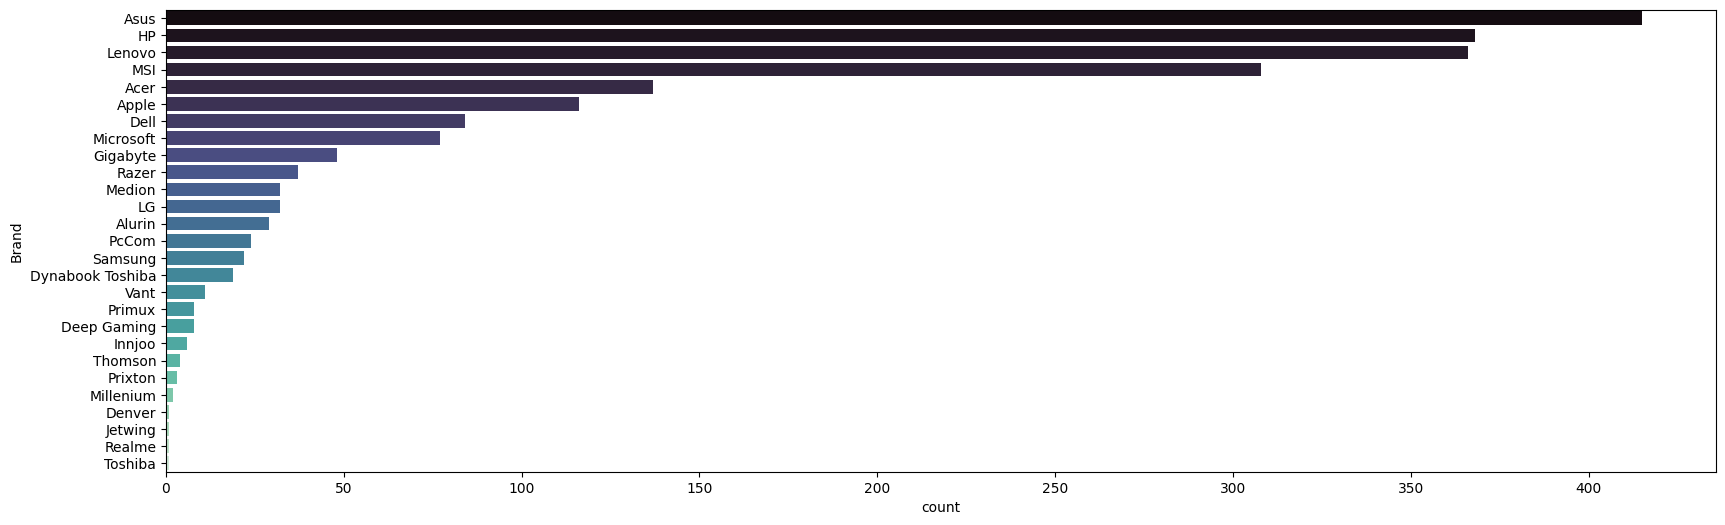

In [91]:
#check laptop specs
plt.figure(figsize=(20,6))
sns.countplot(data=data, y="Brand", order = data["Brand"].value_counts().index, palette="mako")

Jumlah brand laptop terbanyak pada dataset ini adalah Asus dengan total lebih dari 400 model laptop, diikuti oleh HP dan Lenovo dengan ±350 model laptop

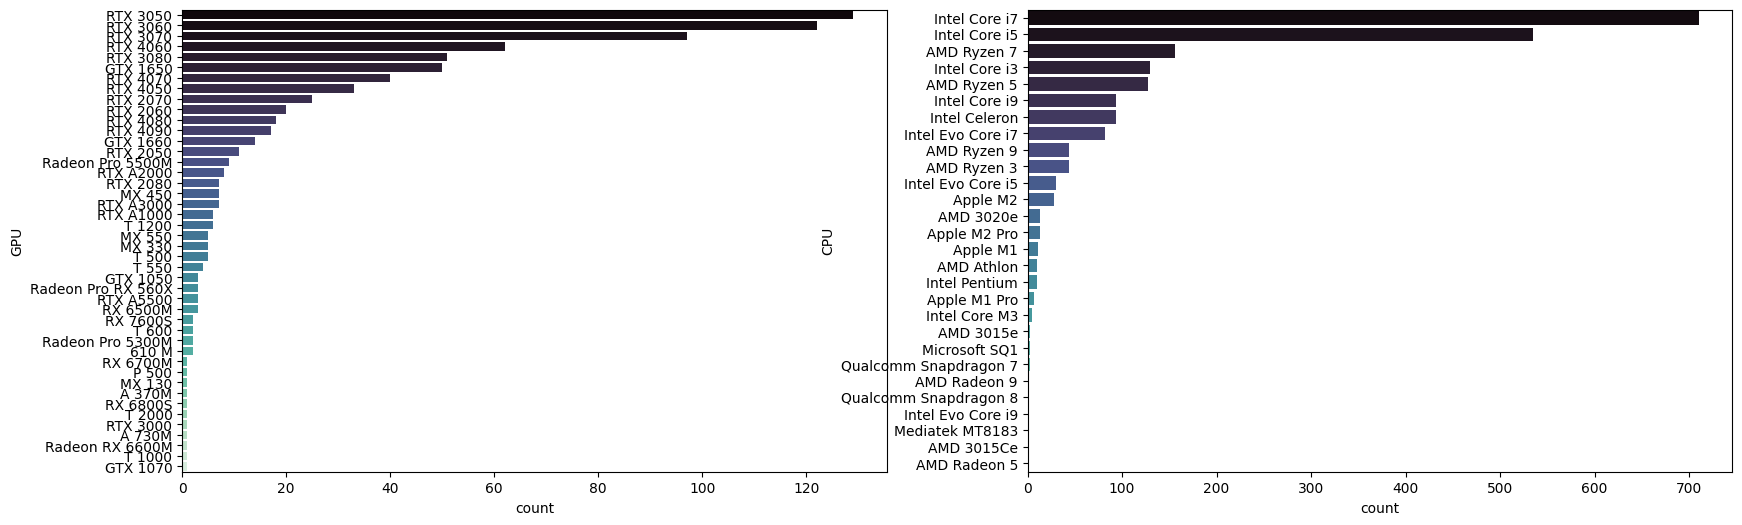

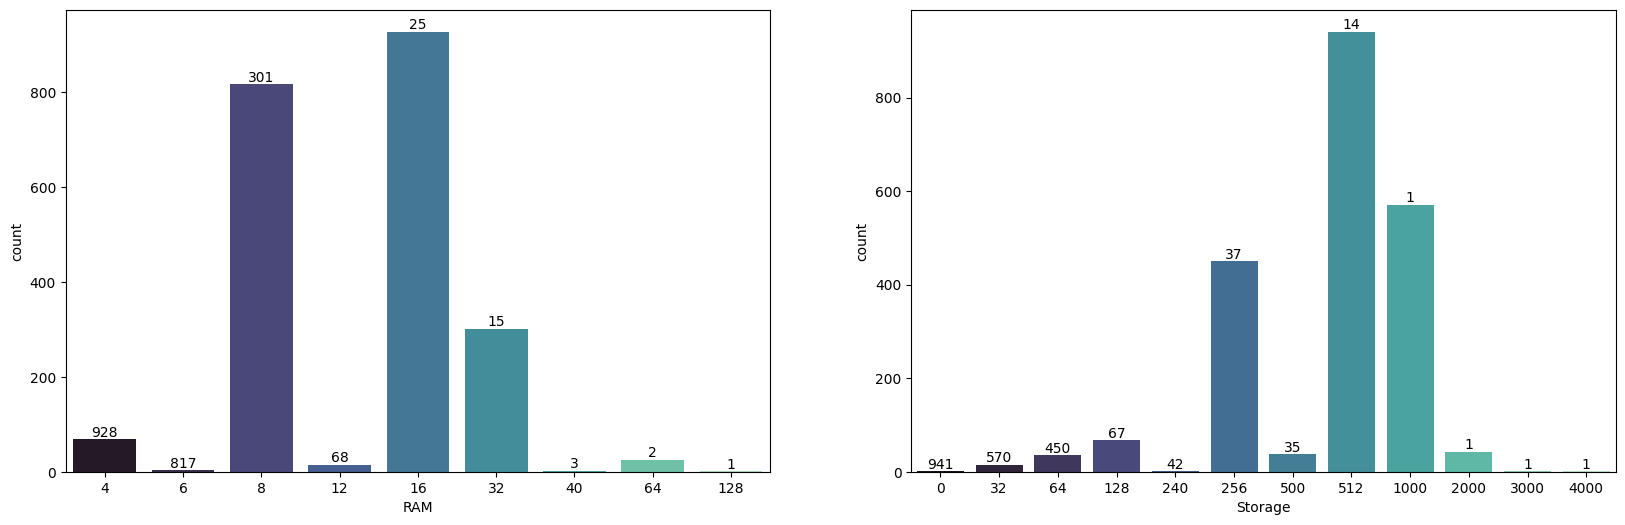

In [92]:
#check laptop specs
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.countplot(data=data, y="GPU", order = data["GPU"].value_counts().index, palette="mako")

plt.subplot(1,2,2)
sns.countplot(data=data, y="CPU", order = data["CPU"].value_counts().index, palette="mako")

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=data, x="RAM", palette="mako")
ax1.bar_label(container=ax1.containers[0], labels=data["RAM"].value_counts().values)

plt.subplot(1,2,2)
ax2 = sns.countplot(data=data, x="Storage", palette="mako")
ax2.bar_label(container=ax2.containers[0], labels=data["Storage"].value_counts().values)

plt.show()

* GPU yang paling banyak digunakan adalah GTX 3050 dan GTX 3060
* Processor yang paling banyak digunakan adalah Intel Core i7 dan Intel Core i5
* Mayoritas Laptop memiliki Ram 8 & 16 GB, serta Storage 256, 512, dan 1000 GB

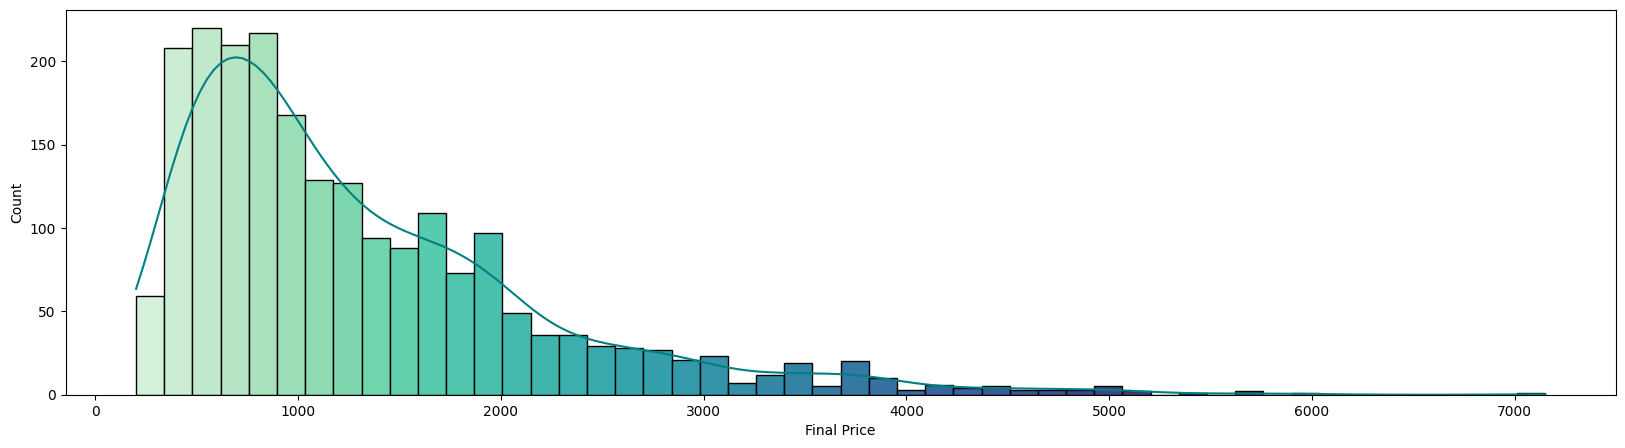

Skewness : 1.6495877663192549


In [93]:
#check price distribution
plt.figure(figsize=(20,5))

palette = sns.color_palette("mako_r",50)

plot = sns.histplot(data=data, x="Final Price", kde=True, bins=50, color="teal")

for bin_,i in zip(plot.patches,palette):
    bin_.set_facecolor(i)
    
plt.show()

print("Skewness :",data["Final Price"].skew())

Distribusi harga laptop pada dataset ini cenderung skewed dengan nilai 1.65, banyak laptop berada pada rentang harga rendah yaitu dibawah $2000, hal ini mungkin mempengaruhi performa prediksi laptop

In [94]:
#handle screen cardinality
screen = pd.DataFrame(data["Screen"].value_counts().rename_axis('screen').reset_index(name='counts'))
sum = screen["counts"].sum()

for i in screen[(screen["counts"]/sum) < 0.05]["screen"]:
     screen.loc[screen["screen"] == i, "screen"] = "Other"
     
screen_new = screen.groupby(screen['screen']).aggregate({'screen': 'first', 'counts': 'sum'})

storage_type = pd.DataFrame(data["Storage type"].value_counts().rename_axis('storage_type').reset_index(name='counts'))
touch_type = pd.DataFrame(data["Touch"].value_counts().rename_axis('touch').reset_index(name='counts'))
status = pd.DataFrame(data["Status"].value_counts().rename_axis('status').reset_index(name='counts'))

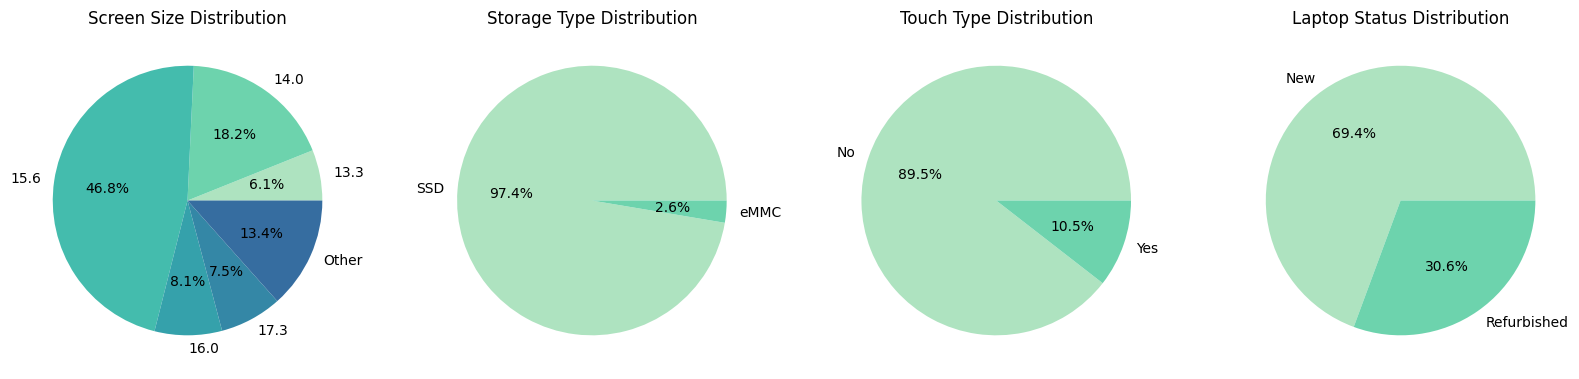

In [95]:
plt.figure(figsize=(20,5))

palette = sns.color_palette("mako_r",10)

plt.subplot(1,4,1)
plt.pie(screen_new["counts"], labels=screen_new["screen"], autopct='%1.1f%%', colors=palette)
plt.title("Screen Size Distribution")

plt.subplot(1,4,2)
plt.pie(storage_type["counts"], labels=storage_type["storage_type"], autopct='%1.1f%%', colors=palette)
plt.title("Storage Type Distribution")

plt.subplot(1,4,3)
plt.pie(touch_type["counts"], labels=touch_type["touch"], autopct='%1.1f%%', colors=palette)
plt.title("Touch Type Distribution")

plt.subplot(1,4,4)
plt.pie(status["counts"], labels=status["status"], autopct='%1.1f%%', colors=palette)
plt.title("Laptop Status Distribution")
plt.show()

* Ukuran layar mayoritas adalah 15.6 dan 14 Inch dengan persentase masing-masing 46.8% dan 18.2%
* Hampir semua jenis laptop pada dataset ini menggunakan Storage SSD, namun perlu diingat terdapat missing values pada storage type sehingga perlu kita observasi lebih lanjut lagi
* Hanya sedikit laptop yang memiliki layar sentuh dengan persentase sekitar 10.5%
* Terdapat beberapa laptop yang merupakan laptop refurbishde, atau laptop stok lama yang telah diperbarui komponennya oleh prabik

In [96]:
#def cramers_v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Correlation
Status : 0.26450718170008297
Brand : 0.241996453068071
Model : 0.2519900783873629
CPU : 0.2517567086906365
GPU : 0.3422702941182396
Touch : 0.095355125133349


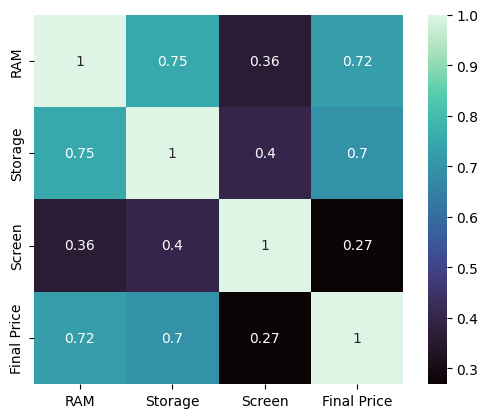

In [97]:
#check correlation plot

#correlation for numerical
corr_matrix = data[["RAM", "Storage", "Screen", "Final Price"]].corr(method="pearson")
sns.heatmap(corr_matrix, annot=True, cmap='mako', square=True)

#correlation for
print("Correlation")
print("Status :",cramers_v(data["Status"], data["Final Price"]))
print("Brand :",cramers_v(data["Brand"], data["Final Price"]))
print("Model :",cramers_v(data["Model"], data["Final Price"]))
print("CPU :",cramers_v(data["CPU"], data["Final Price"]))
print("GPU :",cramers_v(data["GPU"], data["Final Price"]))
print("Touch :",cramers_v(data["Touch"], data["Final Price"]))

* RAM dan Storage memiliki korelasi yang sangat tinggi terhadap Final Price yaitu 0.72 dan 0.7
* Sedangkan kolom lainnya juga memiliki korelasi yang tidak terlalu rendah
* Hanya kolom Touch yang memiliki korelasi dibawah 0.1

In [98]:
data[data.duplicated()]

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price


Tidak terdapat data duplikat pada dataset ini

## 03 - Feature Engineering

Selanjutnya kita bisa melakukan feature engineering agar data yang kita miliki dapat terbaca dengan baik oleh model

### Feature Selection

Kolom nama laptop akan kita drop karena seharusnya nama tidak mempengaruhi harga dari laptop tersebut, dan sudah diwakili oleh brand serta model

In [99]:
#rename columns
columns = data.columns.str.lower()

data.columns = columns

In [100]:
#drop laptop name
data.drop(columns="laptop", inplace=True)

In [101]:
data

,status,brand,model,cpu,ram,storage,storage type,gpu,screen,touch,final price
0,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01
...,...,...,...,...,...,...,...,...,...,...,...
2155,Refurbished,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3060,17.3,No,2699.99
2156,Refurbished,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3070,17.3,No,2899.99
2157,Refurbished,Razer,Blade,Intel Core i7,32,1000,SSD,RTX 3080,17.3,No,3399.99
2158,Refurbished,Razer,Book,Intel Evo Core i7,16,1000,SSD,NaN,13.4,Yes,1899.99


### Handle Missing Values

Kemudian kita bisa melakukan pengecekan terhadap missing values

In [102]:
data.isnull().sum()

status             0
brand              0
model              0
cpu                0
ram                0
storage            0
storage type      42
gpu             1371
screen             4
touch              0
final price        0
dtype: int64

Terdapat banyak missing values pada GPU dan beberapa missing values pada storage type dan screen, hal ini akan kita inspeksi lebih lanjut

In [103]:
data_copy[data["storage type"].isnull()].head(10)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
145,ASUS Chromebook CX1400CNA-BV0210 Intel Celeron...,New,Asus,Chromebook,Intel Celeron,8,32,NaN,NaN,14.0,No,349.00
189,Portátil Alurin Flex Advance Intel Core I5-115...,Refurbished,Alurin,Flex Advance,Intel Core i5,8,0,NaN,NaN,14.0,No,368.70
260,ASUS ROG Strix G16 G614JZ-N3008 Intel Core i7-...,New,Asus,ROG,Intel Core i7,32,1000,NaN,RTX 4080,16.0,No,2599.01
477,Prixton Flex Pro Intel Celeron N4020/4GB/64GB/...,New,Prixton,Flex,Intel Celeron,4,64,NaN,NaN,11.6,Yes,329.95
493,"Apple MacBook Pro Intel Core i5/8GB/256GB/13"" ...",Refurbished,Apple,MacBook Pro,Intel Core i5,8,256,NaN,NaN,13.0,No,634.25
569,"Alurin AMD R5 5500U 15.6"" 8 256 con SO",New,Alurin,Alurin,AMD Radeon 5,8,256,NaN,NaN,15.6,No,499.00
581,"Alurin Intel Core I7 12th 15.6"" 16 500 con SO",New,Alurin,Alurin,Intel Core i7,8,500,NaN,NaN,15.6,No,869.00
600,ASUS F515EA-BQ1625W Intel Core i3-1115G4/8GB/2...,New,Asus,F515,Intel Core i3,8,256,NaN,NaN,15.6,No,408.00
654,HP Chromebook x360 11 G3 Education Edition Int...,New,HP,Chromebook,Intel Celeron,4,32,NaN,NaN,11.6,Yes,282.57
728,HP Chromebook 11 G9 Intel Celeron N4500/4GB/32...,New,HP,Chromebook,Intel Celeron,4,32,NaN,NaN,11.6,No,230.14


Data storage type yang missing values merupakan data missing not at random, dikarenakan beberapa model laptop tersebut merupakan laptop lama dan memiliki harga murah dan model CPU lama, sehingga kita bisa asumsikan bahwa storage laptop tersebut masih menggunakan HDD, sehingga akan kita imputasikan nilai tersebut

In [104]:
data["storage type"].fillna("HDD", inplace=True)

data["storage type"].value_counts()

storage type
SSD     2062
eMMC      56
HDD       42
Name: count, dtype: int64

42 Missing values berhasil diimputasi dengan data HDD

In [105]:
data[data["gpu"].isnull()].head(10)

,status,brand,model,cpu,ram,storage,storage type,gpu,screen,touch,final price
0,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
4,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01
6,New,Lenovo,ThinkPad,AMD Ryzen 5,8,256,SSD,NaN,14.0,No,909.00
7,New,Asus,VivoBook,Intel Core i7,8,512,SSD,NaN,15.6,No,809.01
8,New,Medion,Akoya,Intel Core i5,8,256,SSD,NaN,15.6,No,519.00
10,New,Lenovo,V15,Intel Celeron,8,256,SSD,NaN,15.6,No,349.00
13,New,Lenovo,V15,AMD Ryzen 5,16,512,SSD,NaN,15.6,No,476.99
14,New,Lenovo,IdeaPad,AMD Ryzen 3,8,256,SSD,NaN,15.6,No,391.00


Begitupun missing values pada GPU, karena memang terdapat beberapa laptop yang tidak memiliki GPU atau memiliki GPU yang terintegrasi dengan CPU, sehingga dapat kita imputasikan dengan No GPU

In [106]:
data["gpu"].fillna("No GPU", inplace=True)

data["gpu"].isnull().sum()

0

Semua missing values pada Storage type berhasil diimputasi

In [107]:
data[data["screen"].isnull()].head()

,status,brand,model,cpu,ram,storage,storage type,gpu,screen,touch,final price
624,New,Acer,Extensa,Intel Core i5,8,256,SSD,No GPU,NaN,No,524.99
1430,New,HP,Envy,Intel Core i7,16,512,SSD,RTX 2050,NaN,Yes,1863.52
1503,New,Lenovo,IdeaPad,AMD Ryzen 5,16,512,SSD,RTX 3060,NaN,No,1505.00
1548,New,Lenovo,ThinkPad,Intel Core i7,16,512,SSD,RTX A2000,NaN,No,2569.00


In [108]:
data["screen"].mode()

0    15.6
Name: screen, dtype: float64

Untuk tipe layar, akan kita gunakan kategori layar yang paling banyak digunakan yaitu 15.6 inch

In [109]:
data["screen"].fillna(15.6, inplace=True)

data.isnull().sum()

status          0
brand           0
model           0
cpu             0
ram             0
storage         0
storage type    0
gpu             0
screen          0
touch           0
final price     0
dtype: int64

Semua missing values berhasil kita imputasi

### Handle Outliers

Walaupun terdapat beberapa data angka, sebenarnya data-data tersebut merupakan data Kategorikal nominal sehingga tidak kita lakukan handling outliers

### Split Target and Feature

Kita pisahkan antara independent label dan dependent label (*final price*)

In [110]:
#split X and y
X = data.drop(columns="final price")
y = data["final price"]

### Split Train-Test

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.9, random_state=5)

X_train.shape, y_train.shape

((1944, 10), (1944,))

Train-set dan Test-set kita bagi dengan rasio 90-10

### Feature Encoding

In [112]:
for i in X:
    print(X[i].unique(), "\n")

['New' 'Refurbished'] 

['Asus' 'Alurin' 'MSI' 'HP' 'Lenovo' 'Medion' 'Acer' 'Apple' 'Razer'
 'Gigabyte' 'Dell' 'LG' 'Samsung' 'PcCom' 'Microsoft' 'Primux' 'Prixton'
 'Dynabook Toshiba' 'Thomson' 'Denver' 'Deep Gaming' 'Vant' 'Innjoo'
 'Jetwing' 'Millenium' 'Realme' 'Toshiba'] 

['ExpertBook' 'Go' 'Katana' '15S' 'Crosshair' 'ThinkPad' 'VivoBook'
 'Akoya' 'Victus' 'V15' 'Thin' 'ROG' 'IdeaPad' 'Cyborg' 'M515UA' 'TUF'
 'Aspire' 'Pavilion' 'Vector' 'Chromebook' 'Omen' 'ZenBook' 'Creator'
 'MacBook Air' 'ThinkBook' '250' 'Modern' '255' 'MacBook Pro' 'Prestige'
 'Stealth' 'Pulse' 'Blade' 'Legion' 'Raider' 'ProBook' 'F515' 'G5'
 'Vostro' 'Nitro' 'Gram' 'E410' 'Flex Advance' 'Bravo' 'Aero' 'Yoga'
 'Galaxy Book' 'Erazer' 'Summit' 'Ultra' 'Extensa' 'Flex' 'EliteBook'
 'Revolt' 'Latitude' 'Envy' 'Deputy' 'Predator' 'Surface Laptop' '14w'
 'Titan' 'Ioxbook' 'Aorus' 'Swift' 'Surface Go' 'Netbook Pro'
 'Surface Pro' 'Notebook' '470' 'Spectre' 'Alurin' 'Satellite Pro' 'XPS'
 'ConceptD' 'E510' 'Beast'

Untuk data cateogircal terdapat beberapa kolom yang memiliki kardinalitas tinggi, jika kita menggunakan One Hot Encoder pada kolom ini akan menghasilkan dimensionality yang tinggi. sehingga akan kita gunakan Count Encoder pada data tersebut

In [113]:
#define column

label_col = ["brand", "model","cpu", "gpu", "storage type"]
onehot_col = ["status", "touch"]
num_col = ["ram", "storage", "screen"]

In [114]:
#define encoder and scaler

model_catboost = CountEncoder(handle_unknown=-1)
model_onehot = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist')
model_scaler = MinMaxScaler()

In [115]:
transformers = ColumnTransformer([('catboost_encoder', model_catboost, label_col),
                ('onehot_encoder', model_onehot, onehot_col),
                ('scaler', model_scaler, num_col)])

Kita akan gunakan ColumnTransformer yang akan digunakan pada Pipeline nantinya

## 04 - Model Definition

### Linear Regression

In [116]:
model_linreg = LinearRegression()

pipeline_linreg = Pipeline([
    ('transformer', transformers),
    ('linreg', model_linreg)
])

In [117]:
pipeline_linreg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('catboost_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               handle_unknown=-1),
                                                  ['brand', 'model', 'cpu',
                                                   'gpu', 'storage type']),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['status', 'touch']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['ram', 'storage',
                                                   'screen'])])),
                ('linreg', LinearRegression())])

In [118]:
model_linreg.coef_

array([-9.83389942e-01,  1.69832975e+00, -1.60548143e-01, -3.00567070e-01,
        7.12269817e-02,  1.11225816e+02, -1.11225816e+02, -1.98413000e+02,
        1.98413000e+02,  4.68112643e+03,  3.16069274e+03, -1.95600053e+02])

### Decision Tree

In [119]:
model_dt = DecisionTreeRegressor()

pipeline_dt = Pipeline([
    ('transformer', transformers),
    ('svm', model_dt)
])

In [120]:
pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('catboost_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               handle_unknown=-1),
                                                  ['brand', 'model', 'cpu',
                                                   'gpu', 'storage type']),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['status', 'touch']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['ram', 'storage',
                                                   'screen'])])),
                ('svm', DecisionTreeRegressor())])

### Random Forest

In [121]:
model_rf = RandomForestRegressor()

pipeline_rf = Pipeline([
    ('transformer', transformers),
    ('rf', model_rf)
])

In [122]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('catboost_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               handle_unknown=-1),
                                                  ['brand', 'model', 'cpu',
                                                   'gpu', 'storage type']),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['status', 'touch']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['ram', 'storage',
                                                   'screen'])])),
                ('rf', RandomForestRegressor())])

###  XGBoost

In [123]:
model_xg = XGBRegressor(random_state=5)

pipeline_xg = Pipeline([
    ('transformers', transformers),
    ('xg', model_xg)
])

In [124]:
pipeline_xg.fit(X_train, y_train)

Pipeline(steps=[('transformers',
                 ColumnTransformer(transformers=[('catboost_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               handle_unknown=-1),
                                                  ['brand', 'model', 'cpu',
                                                   'gpu', 'storage type']),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['status', 'touch']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['ram', 'storage',
                                                   'screen']...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=5, ...))])

## 05 - Model Evaluation

Setelah melakukan pendefinisian pada model, kita akan lakukan evaluasi terhadap hasil prediksi menggunakan MAE dan RMSE, kemudian ktia akan memilih model terbaik berdasarkan nilai terkecil

In [125]:
#train prediciton
y_pred_linreg_train = pipeline_linreg.predict(X_train)
y_pred_svm_train = pipeline_dt.predict(X_train)
y_pred_rf_train = pipeline_rf.predict(X_train)
y_pred_xg_train = pipeline_xg.predict(X_train)


#test prediction
y_pred_linreg_test = pipeline_linreg.predict(X_test)
y_pred_svm_test = pipeline_dt.predict(X_test)
y_pred_rf_test = pipeline_rf.predict(X_test)
y_pred_xg_test = pipeline_xg.predict(X_test)

y_pred= pd.DataFrame([["Linear Regression", y_pred_linreg_train, y_pred_linreg_test], 
                      ["Decision Tree", y_pred_svm_train, y_pred_svm_test], 
                      ["Random Forest", y_pred_rf_train, y_pred_rf_test], 
                      ["XGBoost", y_pred_xg_train, y_pred_xg_test]], 
                     columns=["model", "train", "test"])

In [126]:
for index, row in y_pred.iterrows():
    print(row['model'])
    print("MAE - Train :", mean_absolute_error(y_pred=row['train'], y_true=y_train))
    print("MAE - Test :", mean_absolute_error(y_pred=row['test'], y_true=y_test))
    print("RMSE - Train :", mean_squared_error(y_pred=row['train'], y_true=y_train, squared=False))
    print("RMSE - Test :", mean_squared_error(y_pred=row['test'], y_true=y_test, squared=False))
    print()

Linear Regression
MAE - Train : 385.34936319581516
MAE - Test : 372.2572139555853
RMSE - Train : 549.940814711519
RMSE - Test : 502.71445053861737

Decision Tree
MAE - Train : 59.39687127669998
MAE - Test : 271.30651973104057
RMSE - Train : 134.70948881093486
RMSE - Test : 425.76206670854464

Random Forest
MAE - Train : 116.75210297488998
MAE - Test : 227.92411753240802
RMSE - Train : 185.57303617085125
RMSE - Test : 338.3340265318574

XGBoost
MAE - Train : 99.20456900106045
MAE - Test : 221.32750926265012
RMSE - Train : 160.4554492021777
RMSE - Test : 328.99593437566716



Dari Keempat model tersebut didapatkan model paling optimal adalah **XGBoost**, nilai evaluasi dari XGBoost untuk train set memang lebih rendah dibandingkan dengan decision tree, namun pada decision tree terlihat bahwa model sedikit overfitting sehingga nilai pada hasil prediksi jauh lebih tinggi

In [127]:
print("Y True")
print("Max - Train:", round(y_train.max(),2))
print("Max - Test :", round(y_test.max(),2))
print("Min - Train:", round(y_train.min(),2))
print("Min - Test :", round(y_test.min(),2))
print()

for index, row in y_pred.iterrows():
    print(row['model'])
    print("Max - Train:", round(row['train'].max(),2))
    print("Max - Test :", round(row['test'].max(),2))
    print("Min - Train:", round(row['train'].min(),2))
    print("Min - Test :", round(row['test'].min(),2))
    print()

Y True
Max - Train: 7150.47
Max - Test : 4580.73
Min - Train: 201.05
Min - Test : 230.83

Linear Regression
Max - Train: 6844.4
Max - Test : 4651.68
Min - Train: -97.12
Min - Test : 155.06

Decision Tree
Max - Train: 7150.47
Max - Test : 5018.14
Min - Train: 201.05
Min - Test : 201.05

Random Forest
Max - Train: 6046.14
Max - Test : 4618.71
Min - Train: 230.79
Min - Test : 241.96

XGBoost
Max - Train: 7024.56
Max - Test : 4930.28
Min - Train: 219.95
Min - Test : 203.23



Jika kita bandingkan terhadap hasil prediksinya, didapatkan bahwa XGBoost merupakan prediksi yang paling optimal dalam memprediksi nilai tertinggi dan terendah dari train dan test set

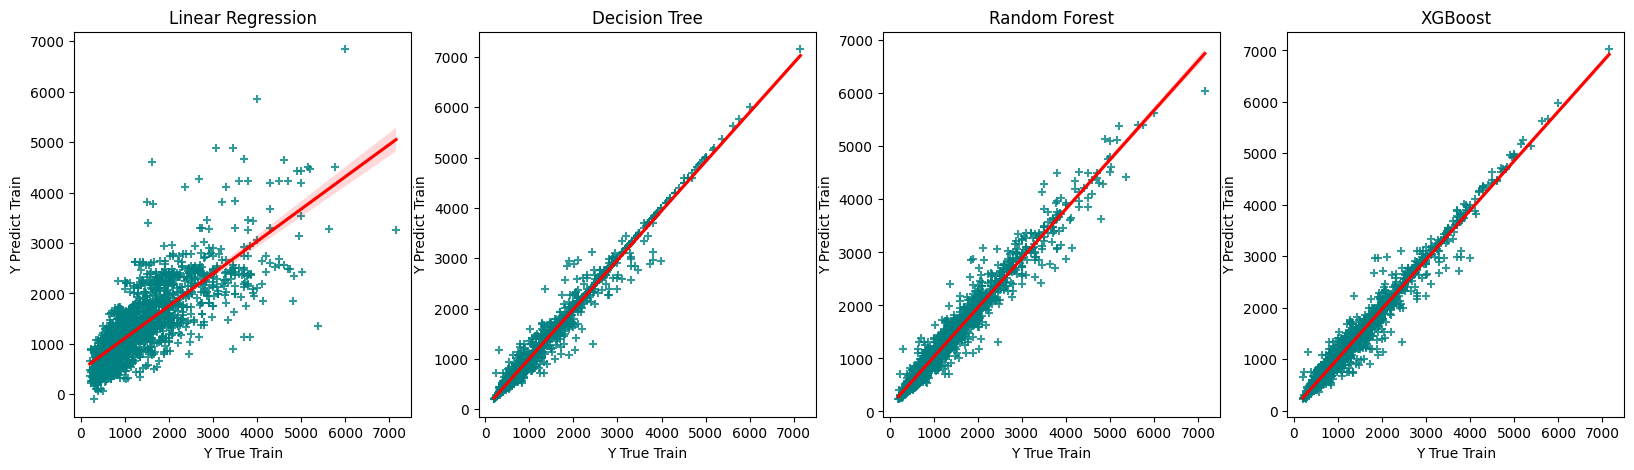

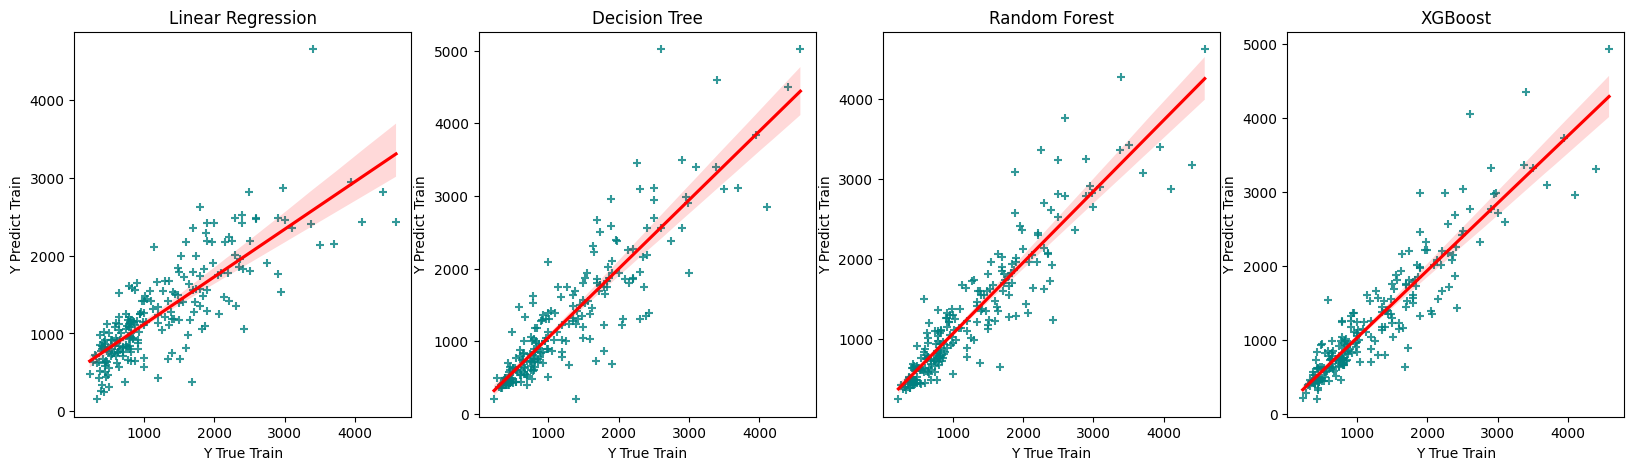

In [128]:
plt.figure(figsize=(20,5))

for index, row in y_pred.iterrows():
    plt.subplot(1,4,index+1)
    sns.regplot(x=y_train, y=row["train"], marker='+', scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
    plt.title(row["model"])
    plt.xlabel("Y True Train")
    plt.ylabel("Y Predict Train")
    
plt.figure(figsize=(20,5))
for index, row in y_pred.iterrows():
    plt.subplot(1,4,index+1)
    sns.regplot(x=y_test, y=row["test"], marker='+', scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
    plt.title(row["model"])
    plt.xlabel("Y True Train")
    plt.ylabel("Y Predict Train")

Dapat dilihat pula pada scatter-plot antara data prediksi dan data asli, XGBoost memiliki data point yang lebih terpusat, ini berarti jarak antara data asli dan data prediksi tidak terlalu jauh

## 06 - Hyperparameter Tuning

Selanjutnya kita akan melakukan Hyperparameter Tuning pada XGBoost dengan parameter sebagai berikut:
* max_depth : 3, 4, 5
* learning_rate : 0.1, 0.01, 0.001
* n_estimators : 100, 500, 1000
* subsample : 0.8, 0.9, 1.0

In [144]:
params = {
    'xg__max_depth': [3, 4, 5],
    'xg__learning_rate': [0.1, 0.01, 0.001],
    'xg__n_estimators': [100, 500, 1000],
    'xg__subsample': [0.8, 0.9, 1.0],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline_xg, param_grid=params, cv=5, scoring='neg_mean_absolute_error', verbose=1)

In [145]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformers',
                                        ColumnTransformer(transformers=[('catboost_encoder',
                                                                         CountEncoder(combine_min_nan_groups=True,
                                                                                      handle_unknown=-1),
                                                                         ['brand',
                                                                          'model',
                                                                          'cpu',
                                                                          'gpu',
                                                                          'storage '
                                                                          'type']),
                                                                        ('onehot_encoder',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                       sparse_output=False),
                                                                         ['status',
                                                                          'touch']),
                                                                        ('scaler',
                                                                         MinMaxScale...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=5, ...))]),
             param_grid={'xg__learning_rate': [0.1, 0.01, 0.001],
                         'xg__max_depth': [3, 4, 5],
                         'xg__n_estimators': [100, 500, 1000],
                         'xg__subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [148]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters found:  {'xg__learning_rate': 0.1, 'xg__max_depth': 5, 'xg__n_estimators': 500, 'xg__subsample': 0.9}
Best score:  -226.49390625008897


Didapatkan hasil parameter terbaik sebagai berikut:
* learning_rate : 0.1
* max_depth : 5 
* n_estimators : 500 
* subsample : 0.9
  
Dengan nilai Mean Absoulte Error pada Cross Validation sebesar 226

Kemudian kita dapat melakukan prediksi pada train dan test set

In [132]:
y_grid_train = grid_search.predict(X_train)
y_grid_test = grid_search.predict(X_test)

In [133]:
print("XGBoost Gridsearch")
print("MAE - Train :", mean_absolute_error(y_pred=y_grid_train, y_true=y_train))
print("MAE - Test :", mean_absolute_error(y_pred=y_grid_test, y_true=y_test))
print("RMSE - Train :", mean_squared_error(y_pred=y_grid_train, y_true=y_train, squared=False))
print("RMSE - Test :", mean_squared_error(y_pred=y_grid_test, y_true=y_test, squared=False))
print()

XGBoost Gridsearch
MAE - Train : 99.36615855715402
MAE - Test : 213.91782320658365
RMSE - Train : 158.62366997303454
RMSE - Test : 319.6003578116707



Didapaktan nilai metrics MAE dan RMSE yang sedikit lebih kecil ketika menggunakan parameter tuning dibandingkan dengan tidak menggunakan parameter tuning

Text(0, 0.5, 'Y Predict')

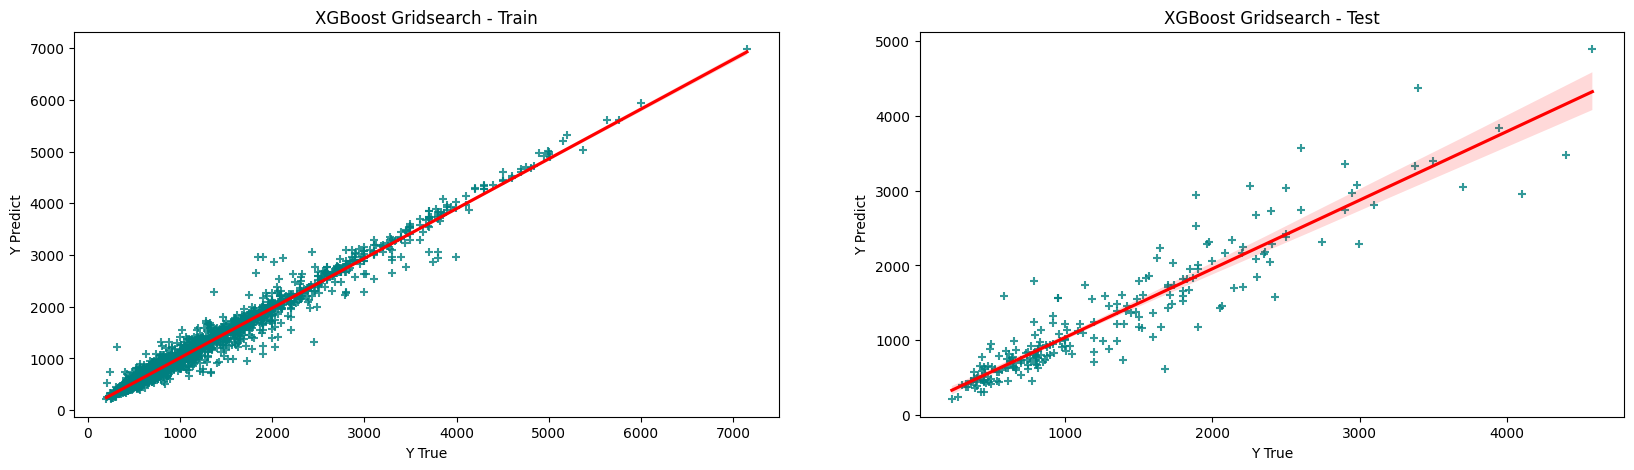

In [134]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.regplot(x=y_train, y=y_grid_train, marker='+', scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
plt.title("XGBoost Gridsearch - Train")
plt.xlabel("Y True")
plt.ylabel("Y Predict")

plt.subplot(1,2,2)
sns.regplot(x=y_test, y=y_grid_test, marker='+', scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
plt.title("XGBoost Gridsearch - Test")
plt.xlabel("Y True")
plt.ylabel("Y Predict")

## 07 - Model Saving

In [135]:
#save file
with open('./deployment/list_num_cols.txt', 'w') as file:
  json.dump(num_col, file)
  
with open('./deployment/list_label_cols.txt', 'w') as file:
  json.dump(label_col, file)
  
with open('./deployment/list_cat_cols.txt', 'w') as file:
  json.dump(onehot_col, file)
  
with open('./deployment/model_grid_xgb.pkl', 'wb') as file:
  pickle.dump(grid_search, file)

## 08 - Model Inferencing

In [136]:
#save file
with open('./deployment/list_num_cols.txt', 'r') as file:
  list_num_cols = json.load(file)
  
with open('./deployment/list_label_cols.txt', 'r') as file:
  list_label_cols = json.load(file)
  
with open('./deployment/list_cat_cols.txt', 'r') as file:
  list_cat_cols = json.load(file)
  
with open('./deployment/model_grid_xgb.pkl', 'rb') as file:
  model_grid_xgb = pickle.load(file)

In [137]:
data_inf = pd.DataFrame([{
    'type' : 'ASUS Rog Strix G614JI',
    'status':  'New',
    'brand':  'Asus',
    'model':  'ROG',
    'cpu':  'Intel Core i9',
    'ram':  32,
    'storage':  1000,
    'storage type':  'SSD',
    'gpu':  'RTX 4070',
    'screen':  16.0,
    'touch':  'No',
}])

data_inf

,type,status,brand,model,cpu,ram,storage,storage type,gpu,screen,touch
0,ASUS Rog Strix G614JI,New,Asus,ROG,Intel Core i9,32,1000,SSD,RTX 4070,16.0,No


In [139]:
#predict
prediction = model_grid_xgb.predict(data_inf)

print("Prediksi harga laptop", data_inf["type"].values, " adalah", round(prediction[0],2), "USD")

Prediksi harga laptop ['ASUS Rog Strix G614JI']  adalah 2758.93 USD


## 11 - Kesimpulan

XGBoost - Before Tuning
MAE - Train : 99.20456900106045
MAE - Test : 221.32750926265012
RMSE - Train : 160.4554492021777
RMSE - Test : 328.99593437566716

XGBoost - After Tuning
MAE - Train : 99.36615855715402
MAE - Test : 213.91782320658365
RMSE - Train : 158.62366997303454
RMSE - Test : 319.6003578116707



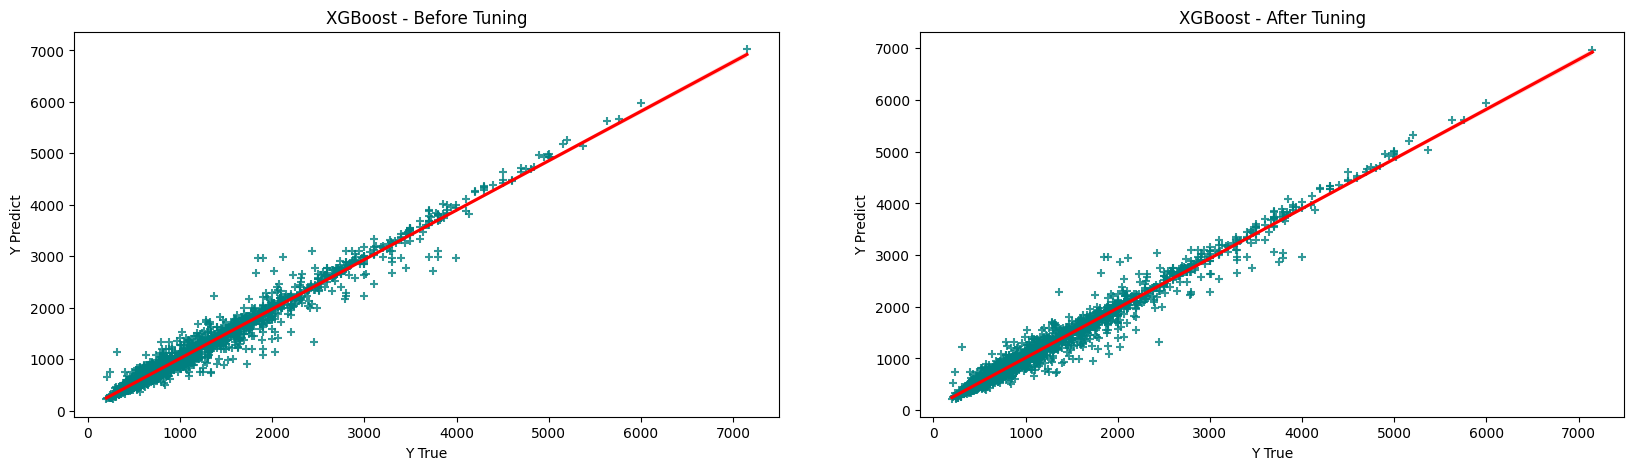

In [153]:

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.regplot(x=y_train, y=y_pred_xg_train, marker='+', scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
plt.title("XGBoost - Before Tuning")
plt.xlabel("Y True")
plt.ylabel("Y Predict")

plt.subplot(1,2,2)
sns.regplot(x=y_train, y=y_grid_train, marker='+', scatter_kws={'color': 'teal'}, line_kws={'color': 'red'})
plt.title("XGBoost - After Tuning")
plt.xlabel("Y True")
plt.ylabel("Y Predict")

print("XGBoost - Before Tuning")
print("MAE - Train :", mean_absolute_error(y_pred=y_pred_xg_train, y_true=y_train))
print("MAE - Test :", mean_absolute_error(y_pred=y_pred_xg_test, y_true=y_test))
print("RMSE - Train :", mean_squared_error(y_pred=y_pred_xg_train, y_true=y_train, squared=False))
print("RMSE - Test :", mean_squared_error(y_pred=y_pred_xg_test, y_true=y_test, squared=False))
print()

print("XGBoost - After Tuning")
print("MAE - Train :", mean_absolute_error(y_pred=y_grid_train, y_true=y_train))
print("MAE - Test :", mean_absolute_error(y_pred=y_grid_test, y_true=y_test))
print("RMSE - Train :", mean_squared_error(y_pred=y_grid_train, y_true=y_train, squared=False))
print("RMSE - Test :", mean_squared_error(y_pred=y_grid_test, y_true=y_test, squared=False))
print()

Setelah dilakukan pemodelan menggunakan 4 pemodelan tersebut didapatkan kesimpulan sebagai berikut:
* 4 Model tersebut bekerja dengan cukup baik dengan nilai MAE dan RMSE yang cukup kecil, dengan nilai terbaik pada XGBoost
* Setelah dilakukan Hyperparameter Tuning pada XGBoost terdapat peningkatan terhadap hasil evaluasi model
* Tetapi tingkat akurasi prediksi dari model ini masih dapat ditingkatkan lagi dengan menambahkan jumlah data untuk training model
* Untuk prediksi laptop pada harga tinggi lebih sering terjadi prediksi yang agak jauh, hal ini dikarenakan data harga yang tersedia pada dataset skewed, dan lebih banyak data untuk harga laptop rendah, sehingga model cenderung memprediksi harga rendah dengan lebih baik

Untuk PT Galaxy Solusindo, pemodelan ini dapat digunakan sebagai langkah awal pengembangan sistem pemesanan laptop yang diinginkan, dikarenakan prediksi yang diberikan tidak berpengaruh fatal dan hanya dijadikan sebagai acuan dalam memperhitungkan harga pemesanan laptop